In [14]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import sympy as sym
import sys

# Visualising the model

In [234]:
def build_states(threshold, system_capacity, parking_capacity):
    
    states_1 = [(0,v) for v in range(0, threshold)]
    states_2 = [(u,v) for v in range(threshold, system_capacity+1) for u in range(parking_capacity+1)]
    all_states = states_1 + states_2    
    
    return all_states

In [185]:
def visualise_ambulance_markov_chain(num_of_servers, threshold, parking_capacity, system_capacity):

    all_states = build_states(threshold, system_capacity, parking_capacity)
    G = nx.MultiDiGraph()
    for i, origin_state in enumerate(all_states):
        for j, destination_state in enumerate(all_states):
            column_adjacent = (destination_state[0] - origin_state[0] == 1 and destination_state[1] - origin_state[1] == 0)
            row_adjacent = (destination_state[1] - origin_state[1] == 1 and destination_state[0] - origin_state[0] == 0)
            if row_adjacent or column_adjacent:
                G.add_edge(origin_state, destination_state, color="blue")

    plt.figure(figsize=(1.5 * (parking_capacity+1), 1.5 * system_capacity))
    pos = {state:list(state) for state in all_states}
    nx.draw_networkx_nodes(G, pos, node_size=2000, nodelist=[state for state in all_states if state[1] < num_of_servers])
    nx.draw_networkx_nodes(G, pos, node_size=2000, nodelist=[state for state in all_states if state[1] >= num_of_servers], node_color='red')
    nx.draw_networkx_edges(G, pos)
    nx.draw_networkx_labels(G, pos)
    plt.axis('off');

# Getting individual entrys of the transition matrix (Symbolic/Exact)

In [217]:
def get_symbolic_transition_matrix_entry(origin, destination, threshold, lambda_a, lambda_o, Lambda, mu, num_of_servers):
    
    row_diff = origin[0] - destination[0]
    column_diff = origin[1] - destination[1]
    
    if row_diff == 0 and column_diff == -1:
        if origin[1] < threshold:
            return Lambda
        return lambda_o
    elif row_diff == -1 and column_diff == 0:
        return lambda_a
    elif row_diff == 0 and column_diff == 1:
        if origin[1] <= num_of_servers:
            return origin[1] * mu
        else:
            return num_of_servers * mu
    elif row_diff == 1 and column_diff == 0 and origin[1] == threshold:
        return threshold * mu
    else:
        return 0

In [218]:
def get_transition_matrix_entry(origin, destination, threshold, lambda_a, lambda_o, mu, num_of_servers):
    
    row_diff = origin[0] - destination[0]
    column_diff = origin[1] - destination[1]
    
    if row_diff == 0 and column_diff == -1:
        if origin[1] < threshold:
            return lambda_a + lambda_o
        return lambda_o
    elif row_diff == -1 and column_diff == 0:
        return lambda_a
    elif row_diff == 0 and column_diff == 1:
        if origin[1] <= num_of_servers:
            return origin[1] * mu
        else:
            return num_of_servers * mu
    elif row_diff == 1 and column_diff == 0 and origin[1] == threshold:
        return threshold * mu
    else:
        return 0

# Get the whole transition matrix (Symbolic/Exact)

In [501]:
def get_symbolic_transition_matrix(number_of_servers, threshold, system_capacity, parking_capacity):
    
    Lambda = sym.symbols('Lambda')
    lambda_o = sym.symbols('lambda')**sym.symbols('o')
    lambda_a = sym.symbols('lambda')**sym.symbols('A')
    mu = sym.symbols('mu')
    
    all_states = build_states(threshold, system_capacity, parking_capacity)
    np.set_printoptions(threshold=sys.maxsize)
    Q = sym.zeros(len(all_states))
    for i, origin_state in enumerate(all_states):
        for j, destination_state in enumerate(all_states):
            Q[i,j] = get_symbolic_transition_matrix_entry(origin=origin_state, destination=destination_state, threshold=threshold, lambda_a=lambda_a, lambda_o=lambda_o, Lambda=Lambda, mu=mu, num_of_servers=num_of_servers)
        Q[i, i] = - sum(Q[i,:])     # Clarify what the diagonal should be
    return Q

In [502]:
def get_transition_matrix(lambda_a, lambda_o, mu, number_of_servers, threshold, system_capacity, parking_capacity):
    
    all_states = build_states(threshold, system_capacity, parking_capacity)
    np.set_printoptions(threshold=sys.maxsize)
    Q = np.zeros((len(all_states),len(all_states)))
    for i, origin_state in enumerate(all_states):
        for j, destination_state in enumerate(all_states):
            Q[i, j] = get_transition_matrix_entry(origin=origin_state, destination=destination_state, threshold=threshold, lambda_a=lambda_a, lambda_o=lambda_o, mu=mu, num_of_servers=num_of_servers)
        Q[i, i] = - sum(Q[i,:])     # Clarify what the diagonal should be
    return Q

# Reviewing the model and transition matrix

In [503]:
lambda_a = 0.4
lambda_o = 0.3
mu = 0.4

num_of_servers = 2
threshold = 1
system_capacity = 3
parking_capacity = 1

In [504]:
Q_sym = get_symbolic_transition_matrix(num_of_servers, threshold, system_capacity, parking_capacity)
all_states = build_states(threshold, system_capacity, parking_capacity)

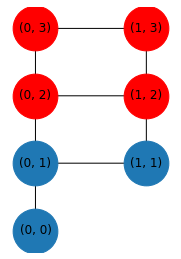

In [505]:
visualise_ambulance_markov_chain(num_of_servers, threshold, parking_capacity, system_capacity)

In [506]:
all_states

[(0, 0), (0, 1), (1, 1), (0, 2), (1, 2), (0, 3), (1, 3)]

In [507]:
Q_sym

Matrix([
[-Lambda,                      Lambda,               0,                             0,                 0,                 0,         0],
[     mu, -lambda**A - lambda**o - mu,       lambda**A,                     lambda**o,                 0,                 0,         0],
[      0,                          mu, -lambda**o - mu,                             0,         lambda**o,                 0,         0],
[      0,                        2*mu,               0, -lambda**A - lambda**o - 2*mu,         lambda**A,         lambda**o,         0],
[      0,                           0,            2*mu,                             0, -lambda**o - 2*mu,                 0, lambda**o],
[      0,                           0,               0,                          2*mu,                 0, -lambda**A - 2*mu, lambda**A],
[      0,                           0,               0,                             0,              2*mu,                 0,     -2*mu]])

# Building the transition matrix

In [508]:
Q = get_transition_matrix(lambda_a, lambda_o, mu, num_of_servers, threshold, system_capacity, parking_capacity)

In [509]:
all_states = build_states(threshold, system_capacity, parking_capacity)
all_states

[(0, 0), (0, 1), (1, 1), (0, 2), (1, 2), (0, 3), (1, 3)]

In [510]:
print(Q)

[[-0.7  0.7  0.   0.   0.   0.   0. ]
 [ 0.4 -1.1  0.4  0.3  0.   0.   0. ]
 [ 0.   0.4 -0.7  0.   0.3  0.   0. ]
 [ 0.   0.8  0.  -1.5  0.4  0.3  0. ]
 [ 0.   0.   0.8  0.  -1.1  0.   0.3]
 [ 0.   0.   0.   0.8  0.  -1.2  0.4]
 [ 0.   0.   0.   0.   0.8  0.  -0.8]]


# Dummy Cells

In [345]:
def get_transition_matrix(lambda_a, lambda_o, mu, num_of_servers, threshold, system_capacity, parking_capacity):
    
    all_states = build_states(threshold, system_capacity, parking_capacity)
    np.set_printoptions(threshold=sys.maxsize)
    Q = np.zeros((len(all_states),len(all_states)))
    for i, origin_state in enumerate(all_states):
        for j, destination_state in enumerate(all_states):
            Q[i,j] = get_transition_matrix_entry(origin=origin_state, destination=destination_state, threshold=threshold, lambda_a=lambda_a, lambda_o=lambda_o, mu=mu, num_of_servers=num_of_servers)
            yield Q[i,j]

In [431]:
Q = get_transition_matrix(lambda_a, lambda_o, mu, num_of_servers, threshold, system_capacity, parking_capacity)

In [432]:
demo = [i for i in Q]

In [454]:
x = sym.symbols('x')
y = sym.symbols('y')

In [458]:
1 - (x + y)

-x - y + 1